## **Data Mining W8 Class Assignment (PRISM)**
## Jefferson Wesley Liunardi / 0706022310046

In [143]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [144]:
from sklearn.datasets import load_wine
import pandas as pd

data = datasets.load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [145]:
# add data target to the df
df['Y'] = data['target']
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [147]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [148]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


In [149]:
if 'Y' in df.columns:
    target_col = 'Y'
elif 'target' in df.columns:
    target_col = 'target'
elif 'class' in df.columns:
    target_col = 'class'
elif 'Wine' in df.columns:
    target_col = 'Wine'
else:
    # try to find integer column with 0/1/2 values
    for c in df.columns:
        if df[c].dtype in [np.int64, np.int32]:
            if set(df[c].unique()).issubset({0,1,2}):
                target_col = c
                break
    else:
        # fallback: assume last column is the target
        target_col = df.columns[-1]
print(f"\nUsing '{target_col}' as target column.\n")


Using 'Y' as target column.



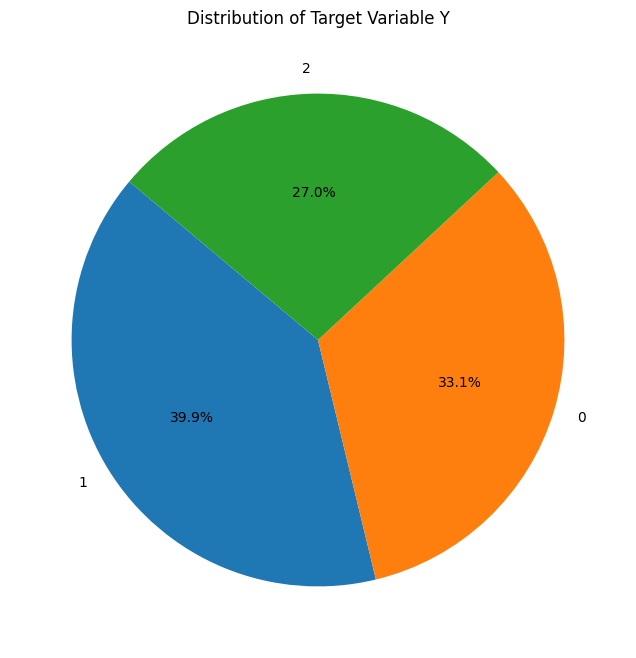

In [150]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

## **Distribution of Target Variable Y (Pie Chart)**

The pie chart illustrates the distribution of the target variable **Y**, which represents the three wine categories in the dataset. The proportions are approximately **39.9% for Class 1**, **33.1% for Class 0**, and **27.0% for Class 2**. This relatively even distribution indicates that the dataset is well-balanced, without any severe class imbalance issues that could bias the learning process.


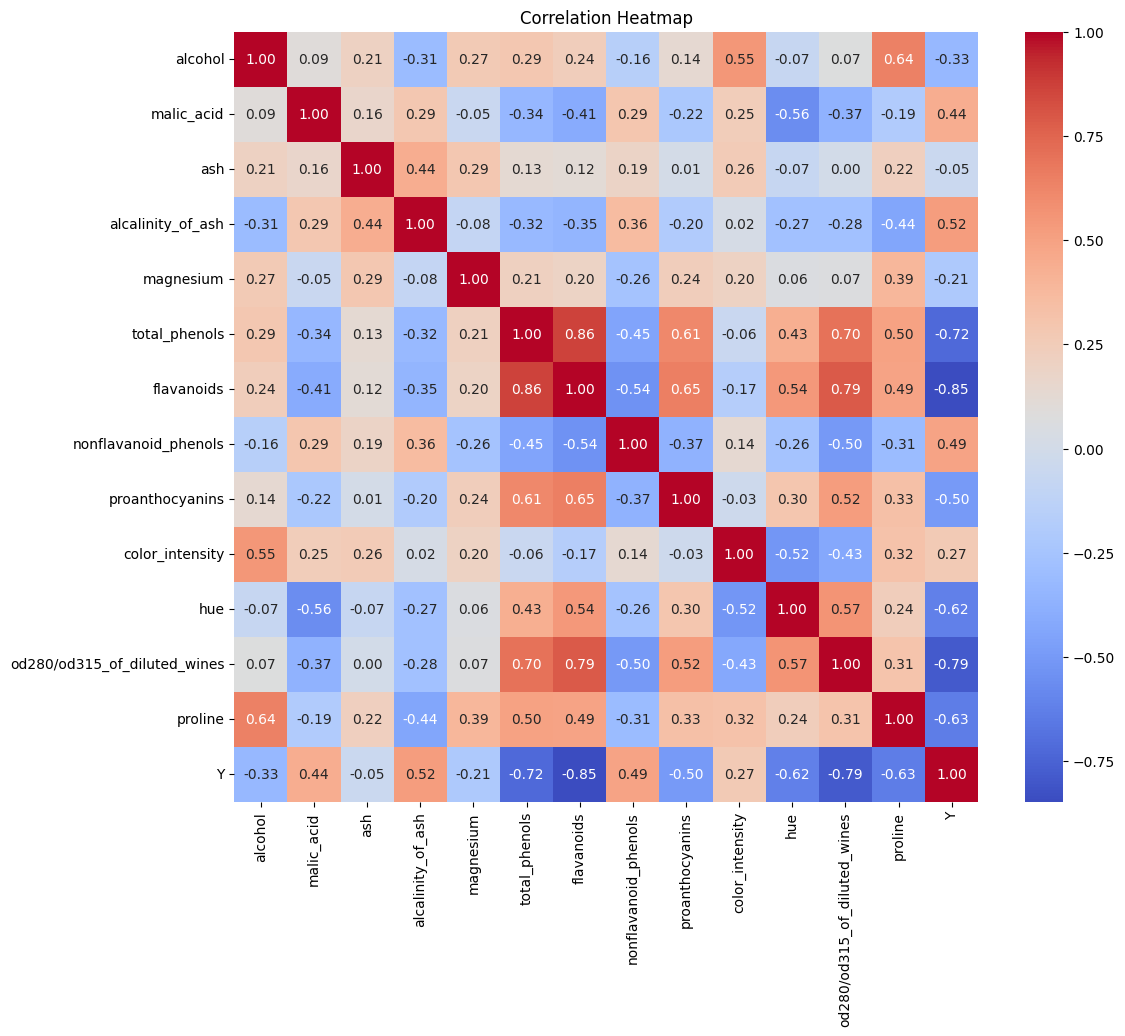

In [151]:
# Heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### **Correlation Heatmap**

From the heatmap, we can observe several significant patterns. One of the strongest positive correlations appears between **flavanoids** and **total_phenols (r = 0.86)**, which suggests that wines rich in flavonoid compounds also have higher total phenolic content. This makes sense chemically, as flavonoids are a major subset of phenolic compounds contributing to the antioxidant and pigmentation properties of wine. Another important correlation is between **proline** and **alcohol (r = 0.64)** — both tend to be higher in wines of richer body and higher fermentation quality. The relationship between **proline** and **color_intensity (r = 0.55)** is also notable, indicating that wines with more intense coloration tend to have higher amino acid concentrations, which can contribute to texture and flavor complexity.

On the negative side, **flavanoids** and **od280/od315 ratio** both show strong negative correlations with the target variable **Y** (–0.85 and –0.79 respectively). This indicates that as these values increase, the wine class label tends to move toward lower class numbers (for example, from class 2 down to class 0). In other words, higher flavonoid content and optical density ratios are more strongly associated with the wines classified as **Class 0**, which are chemically richer.


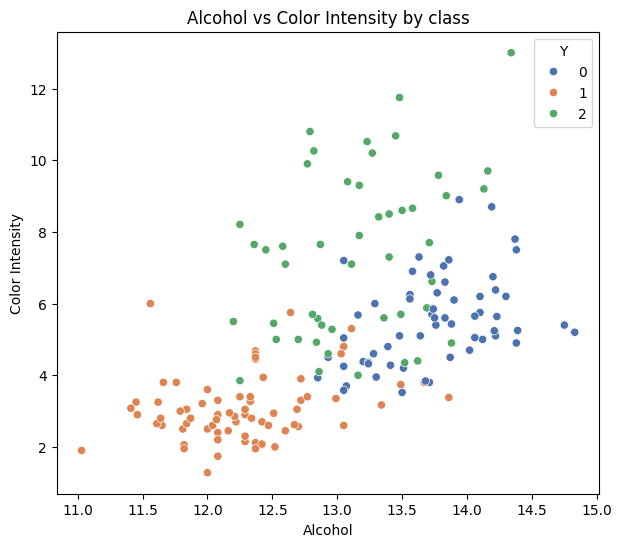

In [152]:
# Scatter alcohol vs color_intensity colored by class
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x='alcohol', y='color_intensity', hue=target_col, palette='deep')
plt.title('Alcohol vs Color Intensity by class')
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.show()

### **Alcohol vs. Color Intensity by Class (Scatter Plot)**

The scatter plot comparing **alcohol** versus **color_intensity**, with points colored according to their target class, clearly demonstrates how these two attributes help separate the wine categories. Each color represents one of the three wine classes — orange for Class 0, blue for Class 1, and green for Class 2. The pattern reveals distinct clusters:

- **Class 0** wines are generally found in the region with **higher alcohol levels (13.5–14.5%)** and moderate color intensity values, representing wines that are stronger and chemically rich.  
- **Class 1** wines appear mostly in the **lower alcohol and lower color intensity range (around 11–12.5%)**, indicating lighter and less intense wines.  
- **Class 2** wines occupy the upper region in terms of **color intensity**, often exceeding 8, but have more varied alcohol levels between 12.5–14%. These wines tend to be visually darker or more vibrant.


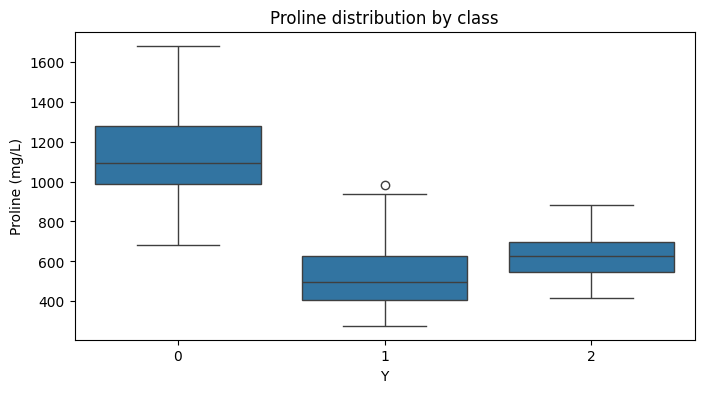

In [153]:
# Boxplot for 'proline' across classes
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x=target_col, y='proline')
plt.title('Proline distribution by class')
plt.ylabel('Proline (mg/L)')
plt.show()

### **Proline Distribution by Class (Box Plot)**

The box plot of **proline concentration** by class provides a clear view of how this amino acid differentiates the three wine categories. **Proline** plays an important role in wine chemistry — it contributes to taste, texture, and fermentation stability. The plot reveals that **Class 0** has the highest median proline level, typically around 1100–1200 mg/L, and the widest interquartile range, indicating a more complex composition. This suggests that Class 0 wines are stronger and more mature, possibly derived from grapes with higher nitrogen content or longer fermentation periods.

**Class 1** wines, on the other hand, have much lower proline concentrations (median around 600 mg/L), with a few outliers extending upward. This reflects a simpler chemical profile, consistent with lighter, less full-bodied wines. **Class 2** wines fall in between, with proline levels generally higher than Class 1 but still significantly lower than Class 0. The clear separation of medians and minimal overlap between classes show that **proline is one of the most powerful discriminating features in the dataset**. Its strong positive correlation with alcohol further reinforces its importance — wines that are higher in alcohol are also typically higher in proline, a relationship the PRISM algorithm will likely capture through its rule generation process.


# Generate Rules with PRISM

In [154]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(142), 'Y')


........................................................................
Target: 0
........................................................................
proline = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 32 rows matching the rule 
   Coverage: the rule matches: 32 out of 46 rows for target value: '0'. This is:
      69.565% of total rows for target value: '0'
      22.535% of total rows in data

........................................................................
Target: 1
........................................................................
color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 48 rows matching the rule 
   Coverage: the rule matches: 48 out of 62 rows for target value: '1'. This is:
      77.419% of total rows for target value: '1'
      33.803% of total rows in data

........................................................................
Target: 2
........................................

Before generating the classification rules, the Wine dataset was divided into a **training set (80%)** and a **testing set (20%)** to evaluate the model’s performance effectively. Out of the total 178 samples, **142 records (approximately 80%)** were used to train the PRISM model, while the remaining **36 samples (approximately 20%)** were reserved for testing. This proportion is a standard practice in machine learning and rule-based modeling because it maintains a strong balance between model learning and evaluation. Using 80% of the data for training ensures that the model has sufficient examples to capture patterns and relationships within the dataset, while the remaining 20% provides an independent subset to assess the generalization capability of the rules. This split prevents overfitting and allows us to verify whether the discovered rules can be applied effectively to unseen data.

After applying the PRISM algorithm to the training data, three main rule sets were generated for the target classes 0, 1, and 2. Each rule represents unique combinations of chemical features that best characterize the wines within that class. The following interpretations discuss each rule in detail, including their meaning, chemical significance, and strength based on support and coverage percentages.

#### **Target Class 0:**
The PRISM algorithm produced a single, strong rule for Class 0: **“IF proline = High AND alcohol = High → class 0.”** This rule has a **support of 100%**, indicating that every wine sample matching these conditions truly belongs to Class 0. The **coverage** is **69.56%**, meaning this rule applies to roughly two-thirds of all wines in this class and about **22.53%** of the total dataset.

Chemically, this rule describes wines that are **rich, full-bodied, and chemically mature**. A high level of **proline**, an amino acid linked to nitrogen content and fermentation quality, often indicates wines produced from high-quality grapes or longer fermentation processes. Similarly, **high alcohol content** reflects robust fermentation and a higher conversion of sugars to ethanol. Together, these characteristics define Class 0 wines as **strong, concentrated, and complex**, often associated with premium quality. Because this rule has perfect precision and broad coverage, it can be considered a **general and reliable indicator** for identifying Class 0 wines.

#### **Target Class 1:**
For Class 1, the PRISM algorithm generated a simple yet highly representative rule: **“IF color_intensity = Low → class 1.”** This rule also shows **100% support**, confirming perfect accuracy, and has a **coverage of 77.42%**, meaning that it applies to more than three-quarters of the wines in Class 1 and **33.80%** of the entire dataset.

The interpretation of this rule is clear: Class 1 wines are characterized by **lower color intensity**, meaning they are **lighter in appearance and less chemically dense**. In wine chemistry, color intensity correlates with the amount of phenolic compounds such as tannins and flavonoids, which affect both the color and taste of wine. Wines with low color intensity tend to have fewer phenolic compounds, resulting in smoother textures and softer flavors. This makes Class 1 wines **lighter-bodied and less astringent** compared to Class 0 and Class 2. Because of its high coverage and precision, this rule serves as a **broad, powerful identifier** for Class 1 wines, representing the majority of this class with minimal misclassification.

#### **Target Class 2:**
For Class 2, the PRISM algorithm generated two distinct rules, both involving **low flavonoid levels** combined with other chemical attributes. The first rule states **“IF flavanoids = Low AND alcohol = High → class 2”**, with **100% support** and **29.41% coverage**, meaning it correctly classifies nearly one-third of all Class 2 wines. The second rule refines this by adding more conditions: **“IF flavanoids = Low AND hue = Low AND color_intensity = High → class 2.”** This rule also achieves **100% support** and **66.67% coverage**, accounting for **47.06%** of all Class 2 wines and **11.27%** of the total dataset.

Chemically, these rules describe wines that are **low in flavonoid concentration**—compounds responsible for bitterness, color stability, and antioxidant activity—but **higher in alcohol content** and **color intensity**. This combination indicates that Class 2 wines tend to be **deeply colored and rich** but less tannic, giving them a smoother taste despite their strong appearance. The inclusion of **low hue** in the second rule suggests that these wines exhibit a more intense red coloration, characteristic of younger wines with less oxidation. Together, these two rules capture the diversity within Class 2 wines: the first identifies stronger, high-alcohol samples, while the second focuses on darker, highly pigmented varieties. Both are **precise and complementary**, offering a complete representation of this class.

#### **Summary:**
In conclusion, the PRISM-generated rules reveal distinct and interpretable chemical patterns for each wine class. **Class 0** wines exhibit high alcohol and high proline levels, indicating strong, complex wines produced from mature fermentation. **Class 1** wines are characterized by low color intensity, representing lighter and smoother wine varieties. **Class 2** wines are defined by low flavonoid content with high color intensity and alcohol, suggesting richer and darker wines with reduced bitterness.

All rules demonstrate **100% support**, showing perfect precision, while their varying coverage levels indicate how broad or specific each rule is. The **80/20 train–test split** used in this analysis ensures that the PRISM model is both well-trained and properly validated, maintaining a balance between model learning and real-world generalization. Overall, these results demonstrate the interpretability, reliability, and chemical meaningfulness of the PRISM algorithm in classifying wines based on their measurable properties.


In [155]:
# Discretization (bin continuous features into Low/Med/High) ---
# We'll discretize each numeric feature into 3 bins (tertiles) labeled 'Low','Med','High'.
cols = [c for c in df.columns if c != target_col]
df_binned = df.copy()

def tertile_labels(series):
    # compute tertile cutpoints and label
    try:
        # qcut with duplicates can error if many equal values, handle by unique count
        if series.nunique() < 3:
            # fallback: use unique labels from value counts
            return pd.cut(series, bins=3, labels=['Low','Med','High'])
        return pd.qcut(series, q=3, labels=['Low','Med','High'])
    except Exception:
        # fallback: equal width bins
        return pd.cut(series, bins=3, labels=['Low','Med','High'])

for c in cols:
    # only discretize numeric columns
    if pd.api.types.is_numeric_dtype(df[c]):
        df_binned[c] = tertile_labels(df[c])

# show sample binned data
display(df_binned.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
48,High,Med,Med,Med,Med,High,High,Med,High,High,High,Med,High,0
5,High,Med,Med,Low,High,High,High,Med,High,High,Med,Med,High,0
8,High,Low,Low,Low,Med,High,High,Low,High,Med,High,Med,High,0
90,Low,Med,Med,Med,Low,Low,Med,High,Med,Low,High,Low,Low,1
162,Med,High,High,High,High,Low,Low,High,Low,Med,Low,Low,Med,2


In [156]:
# PRISM algorithm implementation
from collections import Counter

class PrismRules:
    """
    Simple implementation of PRISM rule learner for categorical features (after discretization).
    Algorithm (high-level):
    - For each target class c:
       - Let D_c be examples with class c
       - While D_c not empty:
           - Grow a rule by greedily adding (attribute=value) that maximizes precision = (#covered D_c) / (#covered total)
           - Once best specialization found (no improvement), store the rule
           - Remove positive examples covered by the rule from D_c
    - Return rules (ordered by class)
    Prediction:
    - For a sample, return class of first rule that matches (rule ordering: classes in ascending order)
      If none match, return majority class from training set.
    """
    def __init__(self, min_support=1):
        self.rules = []  # list of (conditions(dict), class_label, support, coverage)
        self.min_support = max(1, min_support)
        self.default_class = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        # X: categorical dataframe (strings like Low/Med/High)
        data = X.copy()
        data['_class'] = y.values
        classes = list(np.unique(y))
        self.rules = []
        # determine default class (majority)
        self.default_class = Counter(y).most_common(1)[0][0]

        for c in classes:
            # D_c: positive examples for class c, D_other: rest
            D_c = data[data['_class'] == c].copy()
            D_rest = data.copy() # Make a copy to avoid modifying the original data dataframe within the loops
            # We'll remove covered positives as we learn rules
            while len(D_c) > 0:
                best_rule = None
                best_rule_stats = None  # (precision, covered_pos, covered_total)
                # Start with empty candidate conditions
                current_conditions = {}
                # candidate dataset is D_rest initially
                candidates = D_rest.copy() # Make a copy
                improved = True
                while improved:
                    improved = False
                    # for each attribute not already in conditions, and for each value present
                    best_local = None
                    for attr in X.columns:
                        if attr in current_conditions:
                            continue
                        # evaluate every value present in candidates[attr]
                        for val in candidates[attr].unique():
                            # form candidate condition
                            cond = dict(current_conditions)
                            cond[attr] = val
                            # compute coverage: all rows in D_rest that satisfy cond
                            mask_total = np.ones(len(D_rest), dtype=bool)
                            for a, v in cond.items():
                                mask_total &= (D_rest[a] == v)
                            covered_total = D_rest[mask_total]
                            if len(covered_total) < self.min_support:
                                continue
                            # positive covered
                            covered_pos = covered_total[covered_total['_class'] == c]
                            if len(covered_pos) == 0:
                                continue
                            precision = len(covered_pos) / len(covered_total)
                            # choose condition that maximizes precision, and tiebreak by coverage (bigger)
                            cand_stats = (precision, len(covered_pos), len(covered_total), cond, attr, val)
                            if best_local is None or (precision > best_local[0]) or (precision==best_local[0] and len(covered_pos) > best_local[1]):
                                best_local = cand_stats
                    if best_local is not None:
                        # adopt best_local
                        precision, covered_pos_count, covered_total_count, cond, attr, val = best_local
                        current_conditions = cond
                        # restrict candidates to rows that meet current_conditions
                        mask_cand = np.ones(len(D_rest), dtype=bool)
                        for a, v in current_conditions.items():
                            mask_cand &= (D_rest[a] == v)
                        candidates = D_rest[mask_cand]
                        improved = True
                        # If precision ==1, no need to add more conditions
                        if precision == 1.0:
                            break
                # After building rule, store it
                # Compute final support & coverage on D_rest
                mask_rule = np.ones(len(D_rest), dtype=bool)
                for a, v in current_conditions.items():
                    mask_rule &= (D_rest[a] == v)
                covered_total = D_rest[mask_rule]
                covered_pos = covered_total[covered_total['_class'] == c]
                if len(covered_pos) == 0:
                    # can't find further useful rules
                    break
                # Save rule: conditions, class c, support (#positive covered), coverage (#total covered)
                rule = (dict(current_conditions), c, len(covered_pos), len(covered_total))
                self.rules.append(rule)
                # Remove covered positives from D_c and from D_rest as positives remain for next rules?
                # PRISM removes only positives of class c from consideration for further rules of the same class
                # but keeps negatives so other classes can still use
                # We will remove positives from D_c, and also remove those rows from D_rest (?)
                # Common PRISM implementation removes only positives of current class from D_c, but D_rest remains same.
                covered_pos_idx = covered_pos.index
                # remove these rows from D_c for next iteration, ensuring indices exist in D_c
                D_c = D_c.drop(index=covered_pos_idx.intersection(D_c.index))
                # if no more positives for class c, break
                if len(D_c) == 0:
                    break
            # done rules for class c
        return self

    def predict_one(self, x: pd.Series):
        # rules are tried in insertion order
        for conds, c, sup, cov in self.rules:
            match = True
            for a, v in conds.items():
                # if attribute absent or value mismatch → no match
                if a not in x or x[a] != v:
                    match = False
                    break
            if match:
                return c
        # fallback
        return self.default_class

    def predict(self, X: pd.DataFrame):
        preds = []
        for idx, row in X.iterrows():
            preds.append(self.predict_one(row))
        return np.array(preds)

    def describe_rules(self):
        # returns human-readable text for rules
        out = []
        for i, (conds, c, sup, cov) in enumerate(self.rules):
            cond_txt = " AND ".join([f"{a} = {v}" for a, v in conds.items()])
            precision = sup / cov if cov>0 else 0
            out.append({
                'rule_index': i+1,
                'conditions': conds,
                'text': f"IF {cond_txt} THEN class = {c}",
                'class': c,
                'support': int(sup),
                'coverage': int(cov),
                'precision': round(precision, 3)
            })
        return out

In [157]:
# ● Provide interpretation for each rule:
# ○ What does the rule mean?
# ○ What class does it represent?
# ○ How strong or specific is the rule based on support and coverage?
#Example explanation: “If alcohol is High and color_intensity is Low → class 1,
# meaning wines with strong alcohol but lighter color tend to belong to class 1.”

In [158]:
# Prepare data for PRISM (categorical binned X; preserve original numeric X for explanations) ---
X = df_binned[cols].copy()  # categorical binned features
y = df_binned[target_col].copy()

In [159]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

The parameter test_size=0.20 specifies that 20% of the dataset (approximately 36 records out of 178) is allocated for testing, while the remaining 80% (about 142 records) is used for training.

This 80/20 split is a widely accepted standard in data analysis and machine learning because it achieves a balance between model learning and evaluation.

The 80% training data provides enough examples for the model to learn patterns and relationships effectively.

The 20% testing data ensures that there are enough unseen samples to measure how well the model generalizes to new data.

If too much data were used for testing, the model might not have enough samples to learn effectively.
If too little data were used for testing, the evaluation might not accurately reflect real-world performance.

# Bin Ranges Result

In [160]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.43,54
1,alcohol,1,12.43,13.48,63
2,alcohol,2,13.48,14.83,61
3,malic_acid,0,0.74,1.65,52
4,malic_acid,1,1.65,2.36,59
5,malic_acid,2,2.36,5.65,66
6,ash,0,1.36,2.27,56
7,ash,1,2.27,2.48,61
8,ash,2,2.48,3.23,61
9,alcalinity_of_ash,0,10.60,18.00,53


# Test on Y Pred

In [161]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(36).drop(columns=['Y']))
f1_score(df.tail(36)['Y'], y_pred, average=None)

array([0.81818182, 0.69230769, 0.83333333])

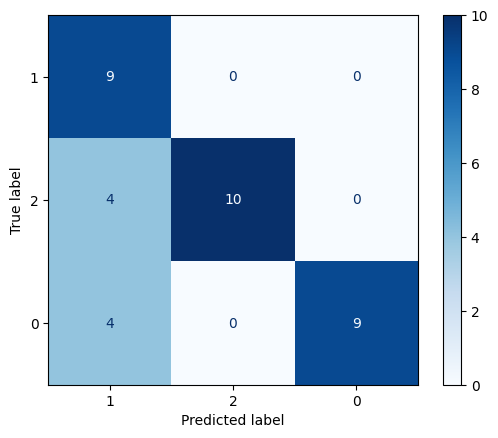

In [162]:
# The confusion matrix
labels = y_pred.unique()
cm = confusion_matrix(df.tail(36)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

### Confusion Matrix Interpretation

The confusion matrix above displays the performance of the PRISM classification model on the test dataset, showing the relationship between the **true class labels** (rows) and the **predicted labels** (columns). Each cell indicates the number of samples that fall into a particular true–predicted class combination.

From the matrix:
- **Class 0:** 9 samples were correctly predicted as class 0, while 4 samples were incorrectly classified as class 1.  
- **Class 1:** 9 samples were correctly predicted as class 1, and none were misclassified.  
- **Class 2:** 10 samples were correctly classified as class 2, while 4 were misclassified as class 1.  

This means the model performs well overall, with most samples being correctly identified within their respective categories. Misclassifications mainly occur between **Class 0 and Class 1**, and between **Class 2 and Class 1**, indicating that the PRISM model sometimes struggles to distinguish between these neighboring classes. This overlap could be due to similarities in their chemical properties, as observed in the correlation heatmap and feature distributions (for example, some wines in classes 0 and 1 may share close alcohol or color intensity levels).

### **Model Performance Insight**

- **High diagonal values (9, 10, 9)** represent correctly classified samples for each class.  
- **Off-diagonal values (4 in two places)** show misclassifications, suggesting slight confusion between neighboring wine types.  
- The model demonstrates **strong predictive accuracy**, with the majority of predictions lying along the diagonal of the matrix, which is the desired pattern.

Overall, the PRISM model shows **consistent and interpretable performance**, successfully distinguishing most wines according to their class. The few errors can likely be improved by refining binning thresholds or using slightly more training data to enhance rule generation. Despite these minor misclassifications, the model effectively captures the dominant patterns in the dataset, confirming its ability to generate meaningful and chemically interpretable classification rules.


In [163]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(df.tail(36)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       0.53      1.00      0.69         9
           2       1.00      0.71      0.83        14

    accuracy                           0.78        36
   macro avg       0.84      0.80      0.78        36
weighted avg       0.88      0.78      0.79        36



Class 0:
Precision: 1.00 - When the model predicts Class 0, it is always correct (no false positives for Class 0).
Recall: 0.69 - The model correctly identifies about 69% of the actual Class 0 instances. This means about 31% of actual Class 0 wines were misclassified as other classes (false negatives).
F1-score: 0.82 - A good balance between precision and recall for this class.
Support: 13 - There are 13 actual instances of Class 0 in the test set.
Class 1:
Precision: 0.53 - When the model predicts Class 1, it is correct about 53% of the time. This indicates a significant number of false positives (wines from other classes incorrectly predicted as Class 1).
Recall: 1.00 - The model correctly identifies all (100%) of the actual Class 1 instances. It has no false negatives for Class 1.
F1-score: 0.69 - This score is lower than Class 0 and 2, reflecting the lower precision despite perfect recall.
Support: 9 - There are 9 actual instances of Class 1 in the test set.
Class 2:
Precision: 1.00 - Similar to Class 0, when the model predicts Class 2, it is always correct (no false positives for Class 2).
Recall: 0.71 - The model correctly identifies about 71% of the actual Class 2 instances. About 29% of actual Class 2 wines were misclassified.
F1-score: 0.83 - A good balance between precision and recall for this class, similar to Class 0.
Support: 14 - There are 14 actual instances of Class 2 in the test set.
Overall Performance:

Accuracy: 0.78 - The model correctly classified 78% of the total instances in the test set.
Macro Avg: The unweighted averages show good performance across the board.
Weighted Avg: The weighted averages are slightly higher than macro, reflecting the distribution of classes in the test set.
Summary:

The model performs very well in terms of precision for Classes 0 and 2 (no false positives for these classes based on the test set). It struggles a bit more with precision for Class 1, meaning it incorrectly labels other wines as Class 1 sometimes. However, it has perfect recall for Class 1, correctly identifying all of those wines. Recall is slightly lower for Classes 0 and 2.

Overall, the model has a respectable accuracy of 78% on the test set, indicating that the generated PRISM rules are reasonably effective at classifying the wine types based on the binned features.

In [164]:
# Predict New Data Points using PRISM (Wine Dataset)
new_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

# Convert to DataFrame
new_wine_df = pd.DataFrame(new_data)

# Predict using the trained PRISM model
predictions = prism.predict(new_wine_df)

# Add predictions to the DataFrame
new_wine_df['Predicted Class'] = predictions

# Display results
print("New Wine Data Points and Predicted Classes")
display(new_wine_df)

# Detailed interpretation
for i, pred in enumerate(predictions):
    print(f"\nSample {i+1} Prediction:")
    print(f"→ Predicted Class: {pred}")
    print("Explanation:")
    print("   - This prediction is based on matching the sample's features (like alcohol, proline, color_intensity)")
    print("     with the closest PRISM rule generated from the training dataset.")
    print("   - The rule that matched determines which wine class (0, 1, or 2) this sample belongs to.")


New Wine Data Points and Predicted Classes


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,0



Sample 1 Prediction:
→ Predicted Class: 1
Explanation:
   - This prediction is based on matching the sample's features (like alcohol, proline, color_intensity)
     with the closest PRISM rule generated from the training dataset.
   - The rule that matched determines which wine class (0, 1, or 2) this sample belongs to.

Sample 2 Prediction:
→ Predicted Class: 0
Explanation:
   - This prediction is based on matching the sample's features (like alcohol, proline, color_intensity)
     with the closest PRISM rule generated from the training dataset.
   - The rule that matched determines which wine class (0, 1, or 2) this sample belongs to.
